# Analyse Exploratrice 

### Auteurs : Octave Jeanne et Elliot Merle 

In [6]:
import pandas as pd 
import numpy as np 
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from statsmodels.regression.linear_model import yule_walker
from sporco.admm import bpdn

# Chargement des données 

In [7]:
test = pd.read_csv("FordB_TEST_cleared.csv") # "cleared" car pré-traiter pour permettre une meilleure lecture et supprimer les annotations
train = pd.read_csv("FordB_TRAIN_cleared.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'FordB_TEST_cleared.csv'

In [ ]:
test_np = test.to_numpy()
train_np = train.to_numpy()

# Définitions 
Toutes les définitions de fonctions sont issues des cours de M. Oudre (https://www.laurentoudre.fr/signalml.html)

In [ ]:
def periodogram(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    Gammax=(np.abs(X)**2)/N
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return Gammax,f  

In [ ]:
def low_pass_filter(x,fc,Fs):
    wc=fc/(Fs/2)
    b, a = signal.butter(4, wc, 'low')
    y = signal.filtfilt(b, a, x)
    return y    

In [ ]:
# Function to compute the centered Fast Fourier Transform (FFT)
def my_fft(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return X,f

In [ ]:
def my_spectrogram(x,Nw,No,Fs):
    f, t, Sxx = signal.stft(x, fs=Fs,nperseg=Nw, noverlap=No, nfft=4*Nw)
    return f,t,Sxx

In [ ]:
# Biased estimator of the autocorrelation function
# lags are comprised between -maxLags and +maxLags
def autocorrelation(x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]
    return gammax,lags

In [ ]:
# Function to compute the relative energy in Nb frequency band
def relative_energy(x,Nb,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    f=np.fft.fftfreq(N, d=1/Fs)
    FNyq=Fs/2
    E=np.zeros((Nb,))
    for i in range(Nb):
        E[i]=np.sum(np.abs(X[(f>i*FNyq/Nb) & (f<=(i+1)*FNyq/Nb)])**2)
    E=E/np.sum(np.abs(X[(f>0) & (f<=Fs/2)])**2)
    return E

def compute_features(X):
    N,M=np.shape(X)
    Y=np.zeros((8,M))
    for i in range(M):
        Y[0,i]=np.mean(X[:,i])
        Y[1,i]=np.var(X[:,i])
        Y[2,i]=np.sqrt(np.sum(X[:,i]**2))
        E=relative_energy(X[:,i],5,1)
        Y[3:8,i]=E
    return Y

In [ ]:
def my_pca(X):
    D,M=np.shape(X)
    X_=np.zeros((D,M))
    for d in range(D):
        X_[d,:]=(X[d,:]-np.mean(X[d,:]))/np.std(X[d,:])
    U,S,Vt=np.linalg.svd(X_)
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    return U, np.dot(S2,Vt), var_exp

In [ ]:
def plot_correlation_circle(U,feature_names,var_exp, S_):
    D,D=np.shape(U)
    figure, axes = plt.subplots()
    for d in range(D):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')   
    datas_pc1 = S_[0,:]
    datas_pc2 = S_[1,:]
    plt.scatter(datas_pc1, datas_pc2)
    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.show()

In [ ]:
import math
def plot_spectrogram(datas, time_window_length, overlap_length, Fs):
    plt.clf()

    # Calculate number of rows and columns (can be square or based on your preference)
    cols = math.ceil(math.sqrt(len(datas)))  # Try to make the figure roughly square
    rows = math.ceil(len(datas) / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration (only if more than 1 row/column)
    axes = axes.flatten()

    # Now plot something on each subplot
    for  i, data in enumerate(datas):

        f,t,Sxx = my_spectrogram(data.values, time_window_length, overlap_length, Fs)
        im = axes[i].pcolormesh(t,f,np.abs(Sxx)**2, shading='auto') # Replace with your actual plot logic
        fig.colorbar(im, ax=axes[i])
        axes[i].set_title(f'Spectrogram Data {i}')
        axes[i].set_xlabel('Temps (s)')
        axes[i].set_ylabel('Fréquence (Hz)')


    # Hide unused subplots if any
    for i in range(len(datas), rows * cols):
        fig.delaxes(axes[i])  # Deletes the extra subplots

    plt.tight_layout()
    plt.show()


# Visualisation

## Log-Periodogram 

Remarque : même si aucune informations n'est donné sur la fréquence d'échantillonage, on peut estimer qu'un moteur a une vitesse au ralenti de 600 tr/min soit 10Hz. Ainsi, la fréquence d'échantillonage doit être au moins 2 fois supérieure à celle de la plus haute fréquence d'étude. Même si le moteur émet des harmoniques, on peut estimer que la fréquence maximale la plus intéressante pour cette étude est de 10Hz. 

In [ ]:
x = test_np[:,0] #premier signal 
Fs = 20 

NameError: name 'test_np' is not defined

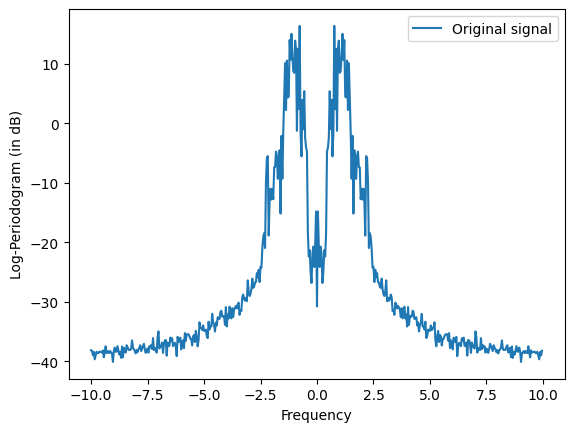

In [ ]:
# Plots of the log-periodograms of x[n] and y[n]
Gammax,f=periodogram(x,Fs)
plt.figure("Plots of the log-periodograms of x[n] and y[n]")
plt.plot(f,10*np.log10(Gammax))
plt.ylabel('Log-Periodogram (in dB)')
plt.xlabel('Frequency')
#plt.xlim((0,20))
plt.legend(('Original signal', 'Noisy signal'))
plt.show()

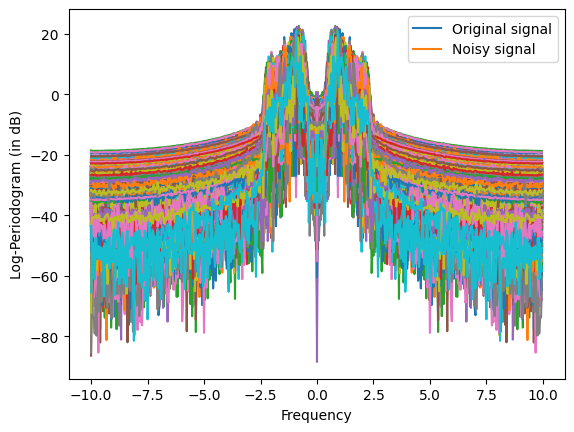

In [ ]:
for i in range(len(test_np[0,:])) : 
    x= test_np[:,i]
    Gammax,f=periodogram(x,Fs)
    plt.figure("Plots of the log-periodograms of x[n] and y[n]")
    plt.plot(f,10*np.log10(Gammax))
    plt.ylabel('Log-Periodogram (in dB)')
    plt.xlabel('Frequency')
    #plt.xlim((0,20))
    plt.legend(('Original signal', 'Noisy signal'))
    
plt.show()

## Fonction d'auto-corrélation

<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\h'
C:\Users\merle\AppData\Local\Temp\ipykernel_5976\800583284.py:7: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$\hat{\gamma}_x[m]$')


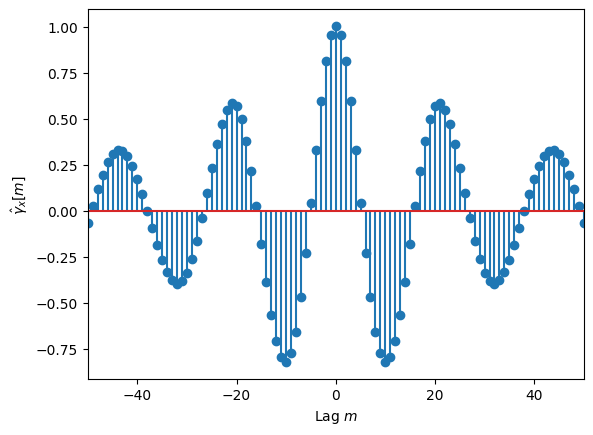

Largest value : 1.0037960764454767 for m=0
Second largest value : 0.9539643816990944 for m=-1


In [ ]:
# Plot the autocorrelation function
maxLags=50
gammax,lags=autocorrelation(x,maxLags)
plt.figure("Plot of the autocorrelation function")
plt.stem(lags,gammax)
plt.xlim((-maxLags,maxLags))
plt.ylabel('$\hat{\gamma}_x[m]$')
plt.xlabel('Lag $m$')
plt.show()

# Determination of the largest values
k=np.argsort(gammax)
print("Largest value : {} for m={}".format(gammax[k[-1]],lags[k[-1]]))
print("Second largest value : {} for m={}".format(gammax[k[-2]],lags[k[-2]]))

In [ ]:
import random
class Data():
    def __init__(self, index, values):
        self.index = index
        self.values = values

datas = []
for index in range(len(test_np[:,0])):
    datas.append(Data(index, test_np[:, index]))

datas = random.sample(datas, 20)

<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:26: SyntaxWarning: invalid escape sequence '\h'
C:\Users\merle\AppData\Local\Temp\ipykernel_5976\1848359117.py:26: SyntaxWarning: invalid escape sequence '\h'
  axes[i].set_ylabel('$\hat{\gamma}_x[m]$')


<Figure size 640x480 with 0 Axes>

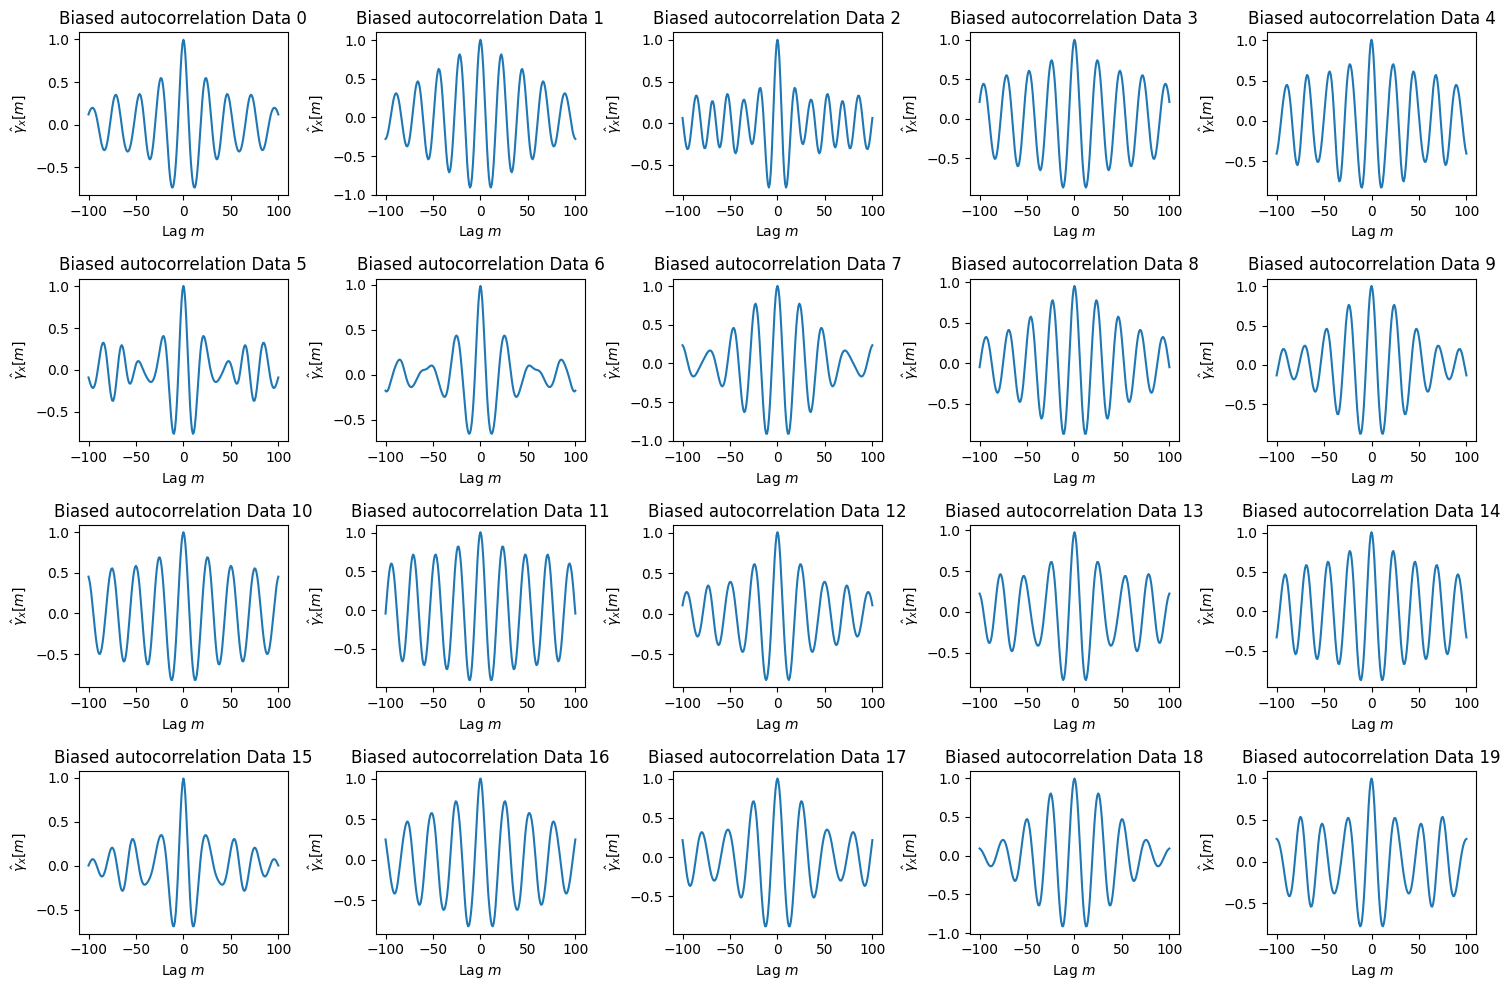

In [ ]:
import math as math 

plt.clf()

maxLags = 100
datas_number = len(datas)

# Calculate number of rows and columns (can be square or based on your preference)
cols = math.ceil(math.sqrt(datas_number))  # Try to make the figure roughly square
rows = math.ceil(datas_number / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

# Now plot something on each subplot
for  i, data in enumerate(datas):

    gammax,lags = autocorrelation(data.values, maxLags)
    

    axes[i].plot(lags, gammax)  # Replace with your actual plot logic
    axes[i].set_title(f'Biased autocorrelation Data {i}')
    axes[i].set_ylabel('$\hat{\gamma}_x[m]$')
    axes[i].set_xlabel('Lag $m$')


# Hide unused subplots if any
for i in range(datas_number, rows * cols):
    fig.delaxes(axes[i])  # Deletes the extra subplots

plt.tight_layout()
plt.show()

## Débruitage Filtre Passe Bas 

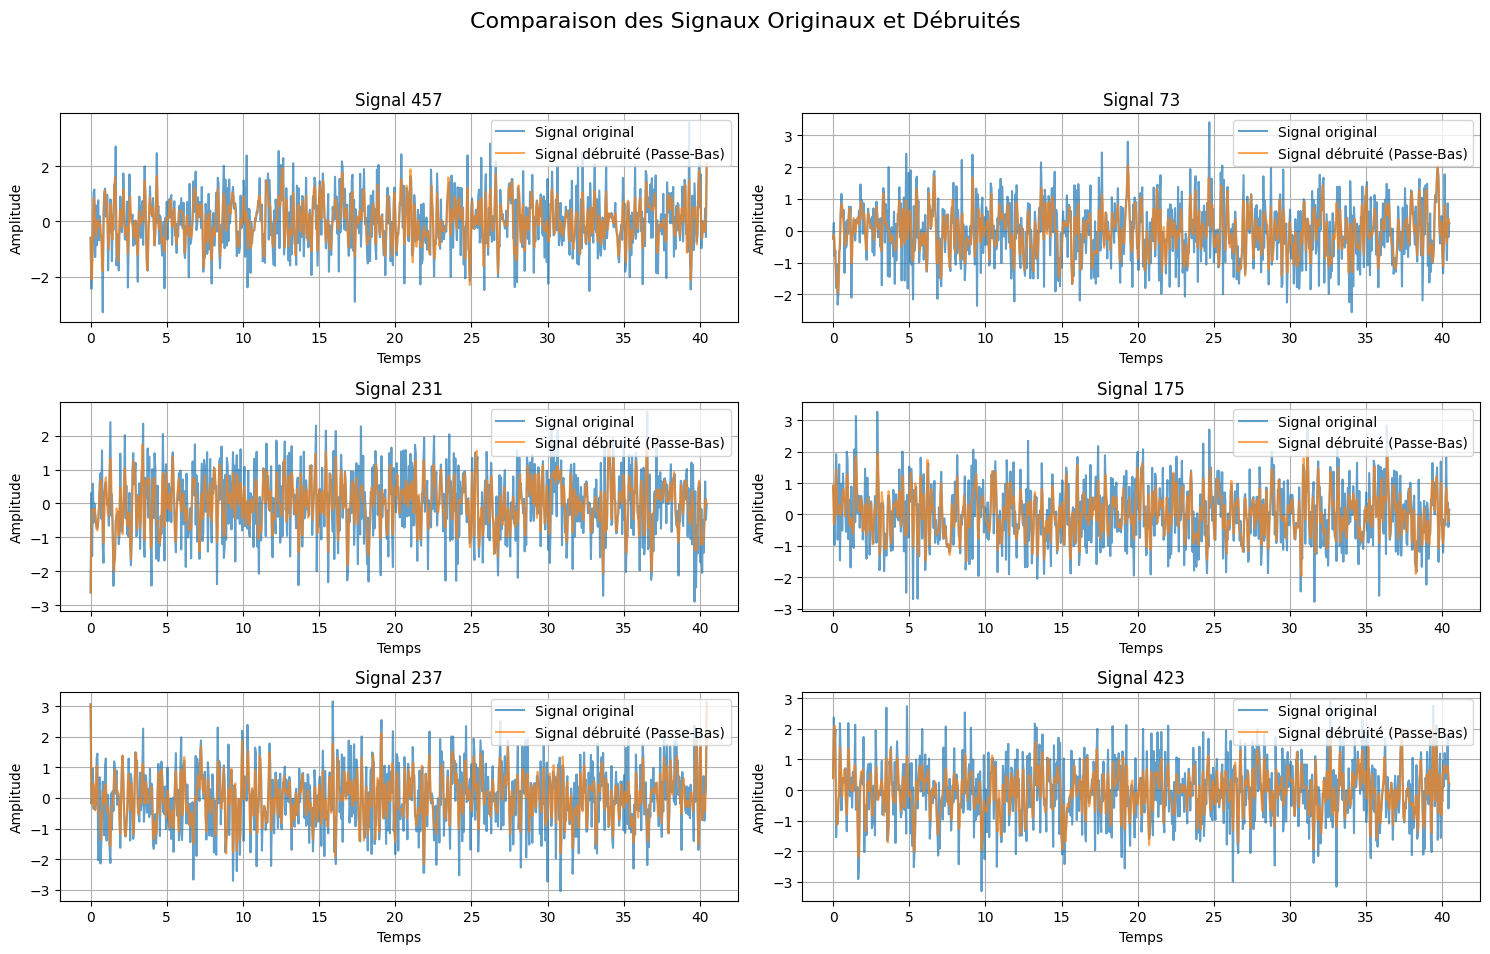

In [ ]:
test_np = test.values.T  
Fs = 20 
fc = 5  

# Sélectionner 6 signaux aléatoires
np.random.seed(42)  # Pour la reproductibilité
num_signals = 6
total_signals = test_np.shape[1]
signal_indices = np.random.choice(total_signals, size=num_signals, replace=False)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.suptitle('Comparaison des Signaux Originaux et Débruités', fontsize=16)

for idx, ax in zip(signal_indices, axs.flatten()):
    x = test_np[:, idx]
    t = np.arange(len(x)) / Fs  
    x_filtered = low_pass_filter(x, fc, Fs)
    
    ax.plot(t, x, label='Signal original', alpha=0.7)
    ax.plot(t, x_filtered, label='Signal débruité (Passe-Bas)', alpha=0.7)
    
    ax.set_xlabel('Temps')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Signal {idx}')
    ax.legend(loc='upper right')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


## Spectrogramme

In [ ]:
import random

class Data():
    def __init__(self, index, values):
        self.index = index
        self.values = values

datas = []
for index in range(test_np.shape[1]):
    datas.append(Data(index, test_np[:, index]))

random.seed(42)  # Pour assurer la reproductibilité
datas = random.sample(datas, 8)


<Figure size 640x480 with 0 Axes>

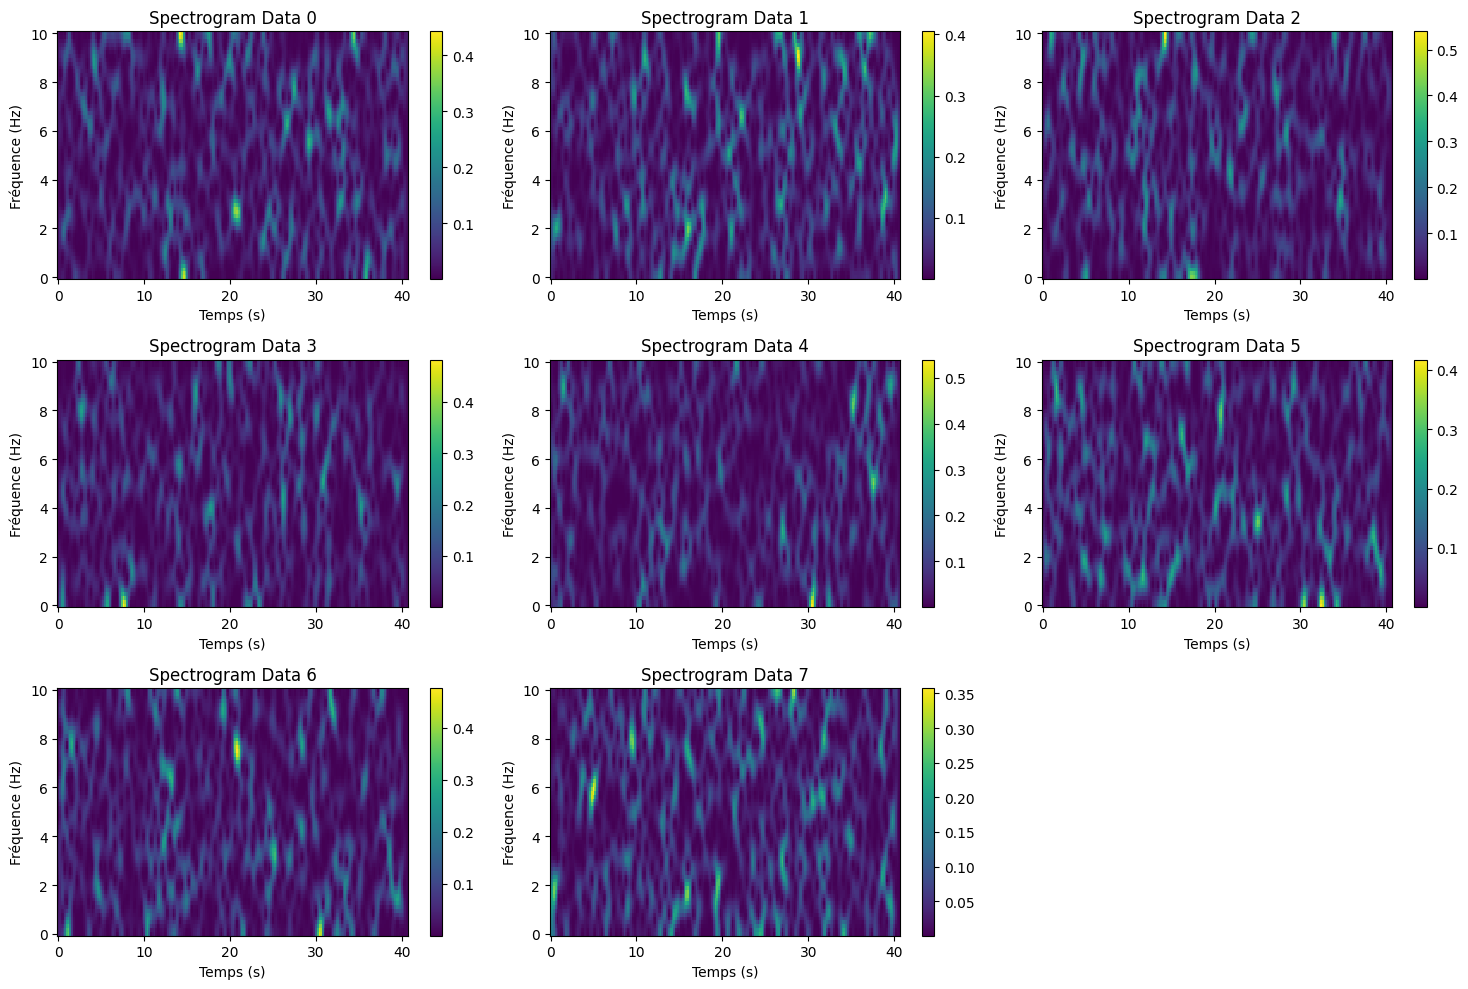

In [ ]:
### import math 
Fs = 20
time_window_length = 32
overlap_length = 28
plot_spectrogram(datas, time_window_length, overlap_length, Fs)

## Analyse en Composante Principale 

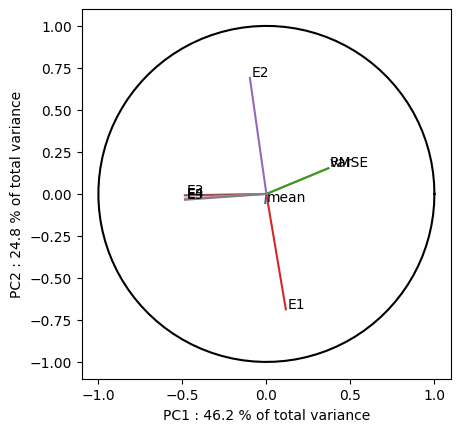

In [ ]:
# Computation of PCA

X1 = train_np
Y1=compute_features(X1)

Y =np.concatenate((Y1,Y1),axis=1)
D,M=np.shape(Y)
U,S_,var_exp=my_pca(Y)

feature_names = [
  'mean',
  'var',
  'RMSE',
  'E1', 'E2', 'E3', 'E4','E5']
plot_correlation_circle(U,feature_names,var_exp, S_)

C:\Users\merle\AppData\Local\Temp\ipykernel_21944\4022146403.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(Y1[0, :], fill=True, palette='magma')
C:\Users\merle\AppData\Local\Temp\ipykernel_21944\4022146403.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(Y1[1, :], fill=True, palette='magma')
C:\Users\merle\AppData\Local\Temp\ipykernel_21944\4022146403.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(Y1[2, :], fill=True, palette='magma')


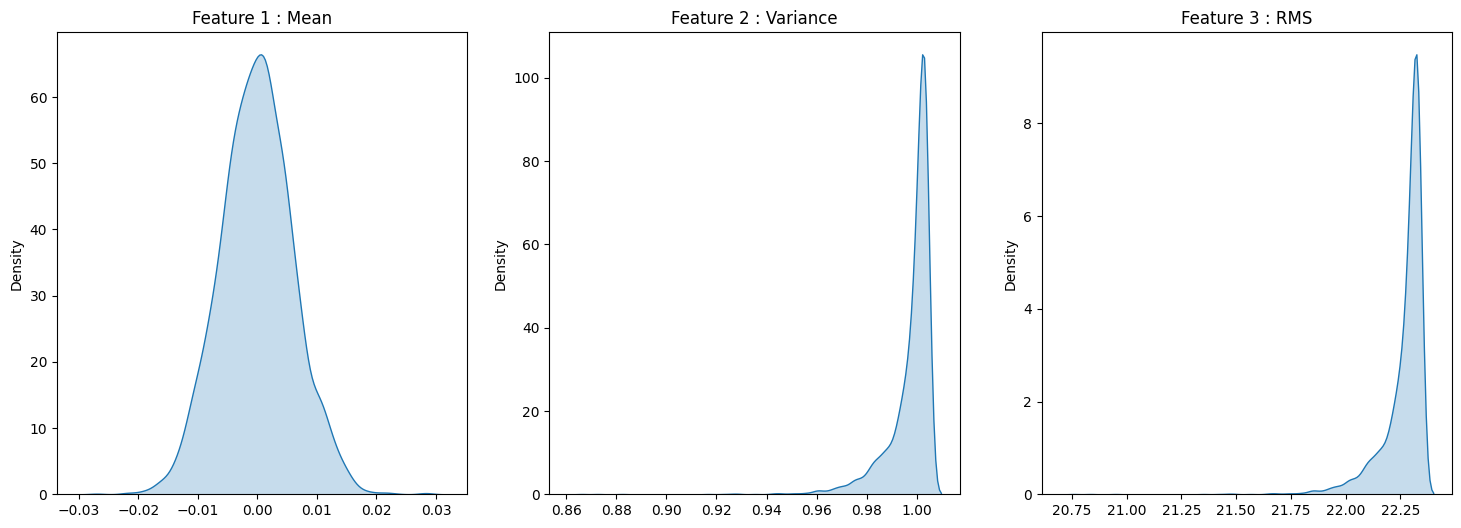

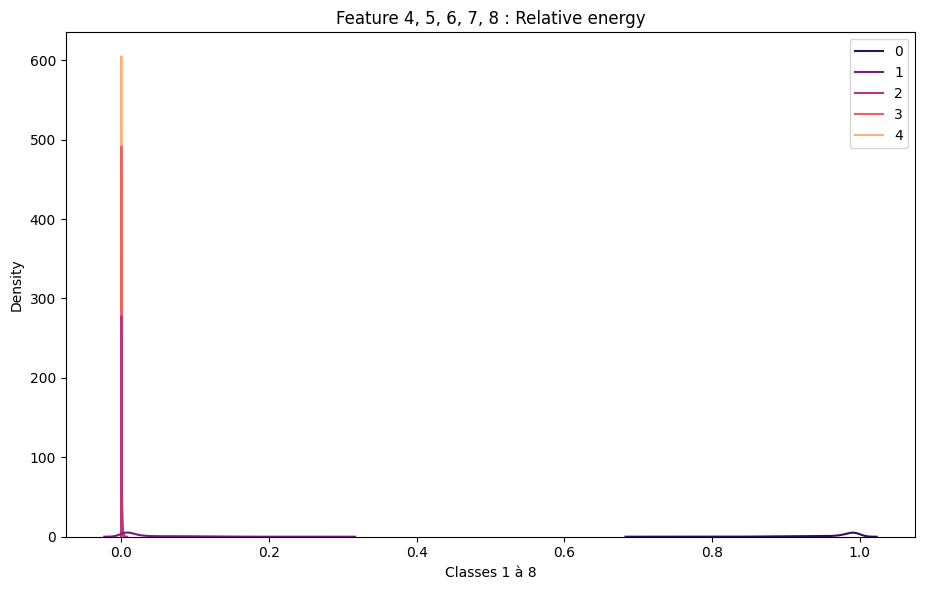

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X1 = train_np
Y1 = compute_features(X1)
# Y2 = compute_features(X2)

plt.figure("Boxplot of the features values on each class (1 to 3)", figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.kdeplot(Y1[0, :], fill=True, palette='magma')
plt.title("Feature 1 : Mean")
plt.subplot(1, 3, 2)
sns.kdeplot(Y1[1, :], fill=True, palette='magma')
plt.title("Feature 2 : Variance")
plt.subplot(1, 3, 3)
sns.kdeplot(Y1[2, :], fill=True, palette='magma')
plt.title("Feature 3 : RMS")

plt.figure("Boxplot of the features values on each class (4 to 8)", figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(np.transpose(Y1[3:8, :]), palette='magma')
plt.title("Feature 4, 5, 6, 7, 8 : Relative energy")
plt.xlabel('Classes 1 à 8')


plt.tight_layout()  
plt.show()


<>:47: SyntaxWarning: invalid escape sequence '\h'
<>:47: SyntaxWarning: invalid escape sequence '\h'
C:\Users\merle\AppData\Local\Temp\ipykernel_5976\1853782649.py:47: SyntaxWarning: invalid escape sequence '\h'
  axes[i].set_ylabel('$\hat{{\gamma}}_x[m]$')


<Figure size 640x480 with 0 Axes>

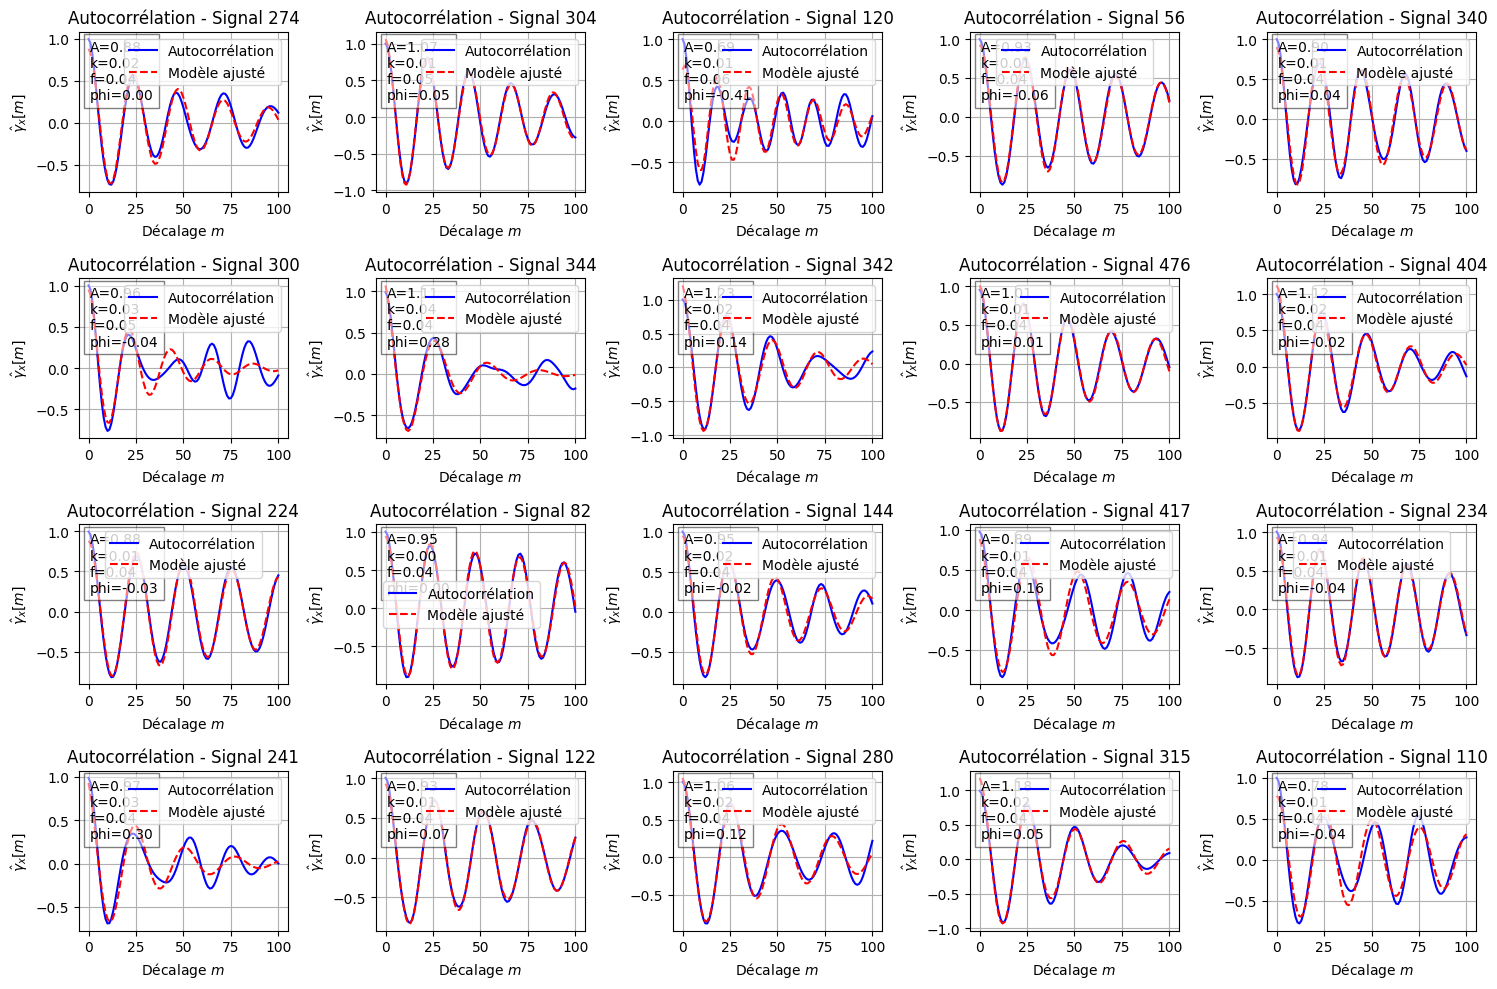

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.clf()

maxLags = 100
datas_number = len(datas)

cols = math.ceil(math.sqrt(datas_number))
rows = math.ceil(datas_number / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

def damped_sine(m, A, k, f, phi):
    return A * np.exp(-k * m) * np.cos(2 * np.pi * f * m + phi)

for i, data in enumerate(datas):

    gammax, lags = autocorrelation(data.values, maxLags)
    
    positive_lags = lags[lags >= 0]
    autocorr = gammax[lags >= 0]
    lags_fit = positive_lags[1:]
    autocorr_fit = autocorr[1:]
    
    initial_guess = [1, 0.01, 0.05, 0]
    try:
        popt, _ = curve_fit(damped_sine, lags_fit, autocorr_fit, p0=initial_guess)
        A_fitted, k_fitted, f_fitted, phi_fitted = popt
        autocorr_fitted = damped_sine(positive_lags, *popt)
        
        axes[i].plot(positive_lags, autocorr, linestyle='-', color='blue', label='Autocorrélation')
        axes[i].plot(positive_lags, autocorr_fitted, linestyle='--', color='red', label='Modèle ajusté')
        axes[i].legend()
    except RuntimeError:
        axes[i].plot(positive_lags, autocorr, linestyle='-', color='blue')
        axes[i].text(0.5, 0.5, 'Ajustement échoué', transform=axes[i].transAxes, ha='center', va='center', color='red')
    
    axes[i].set_title(f'Autocorrélation - Signal {data.index}')
        # Afficher les paramètres ajustés sur le subplot
    axes[i].text(0.05, 0.95, f'A={A_fitted:.2f}\nk={k_fitted:.2f}\nf={f_fitted:.2f}\nphi={phi_fitted:.2f}',
                transform=axes[i].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    axes[i].set_ylabel('$\hat{{\gamma}}_x[m]$')
    axes[i].set_xlabel('Décalage $m$')
    axes[i].grid(True)

for i in range(datas_number, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


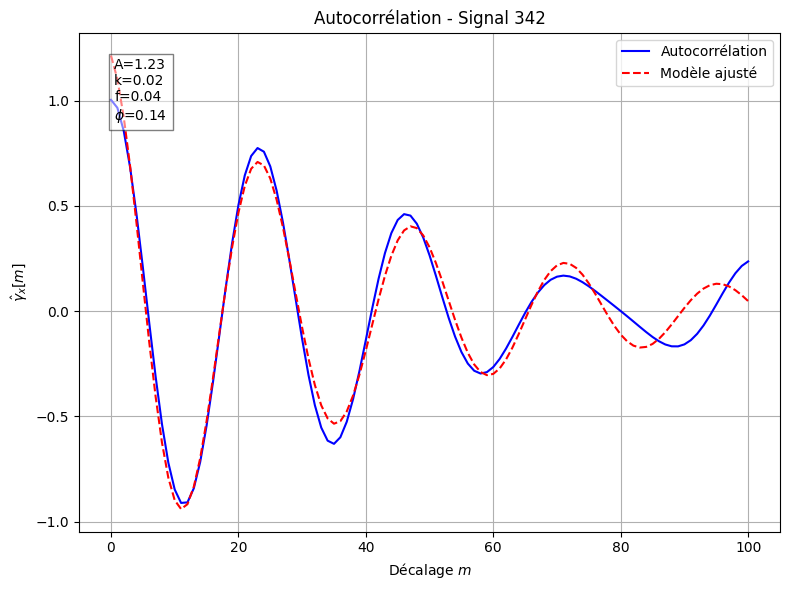

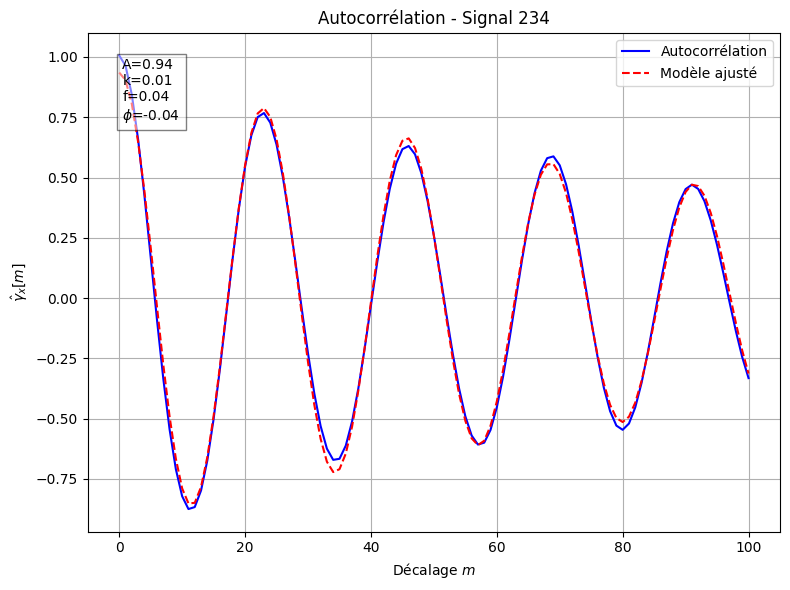

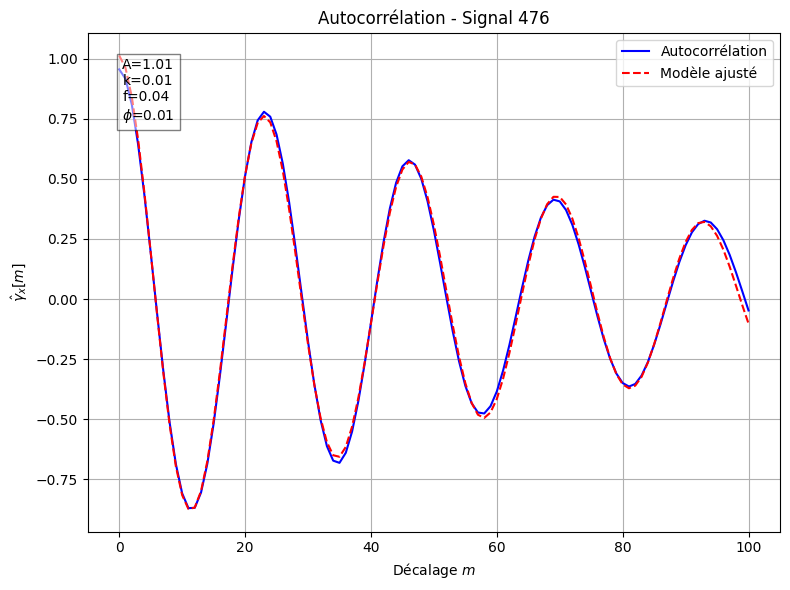

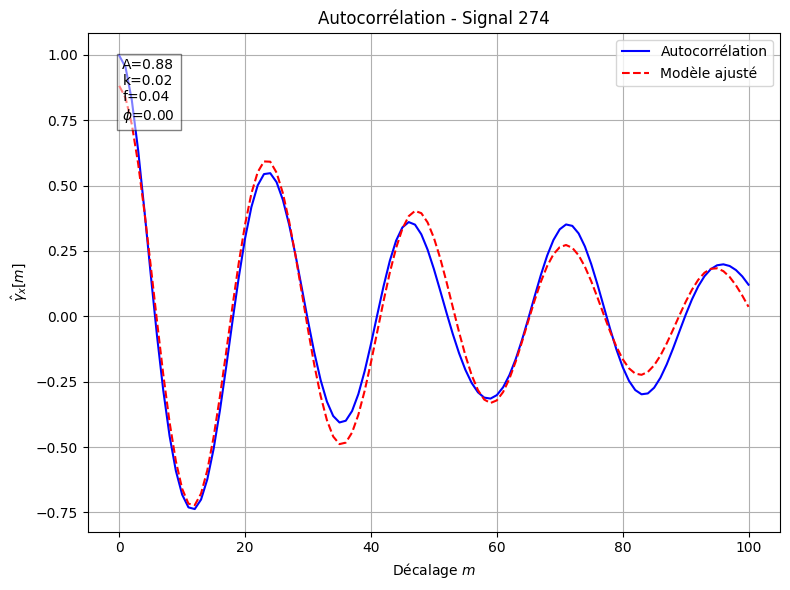

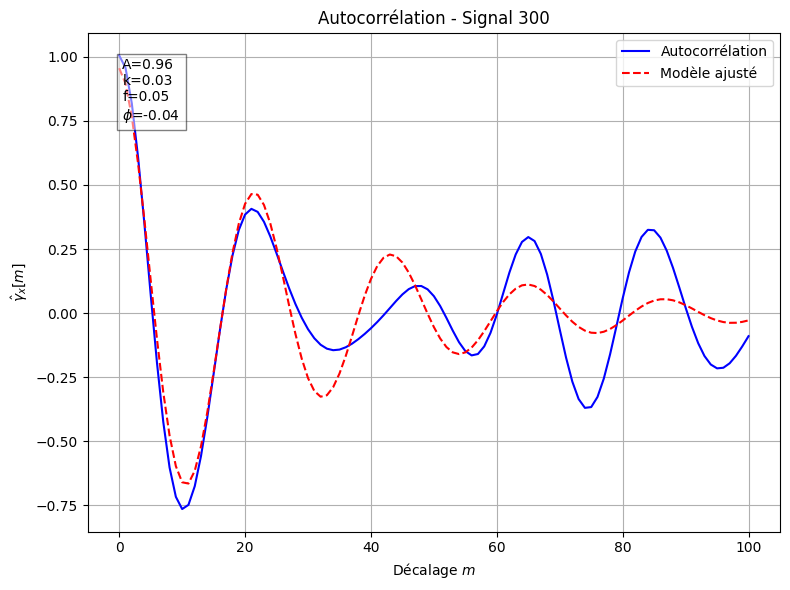

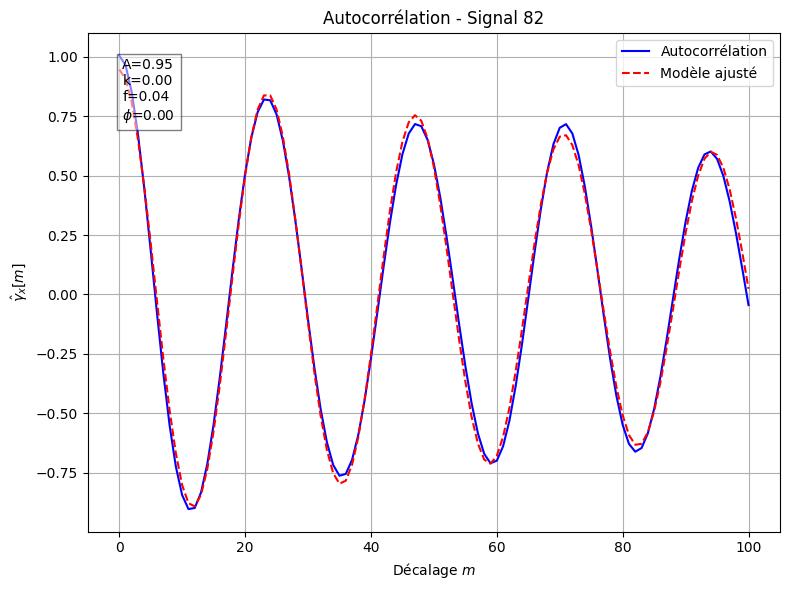

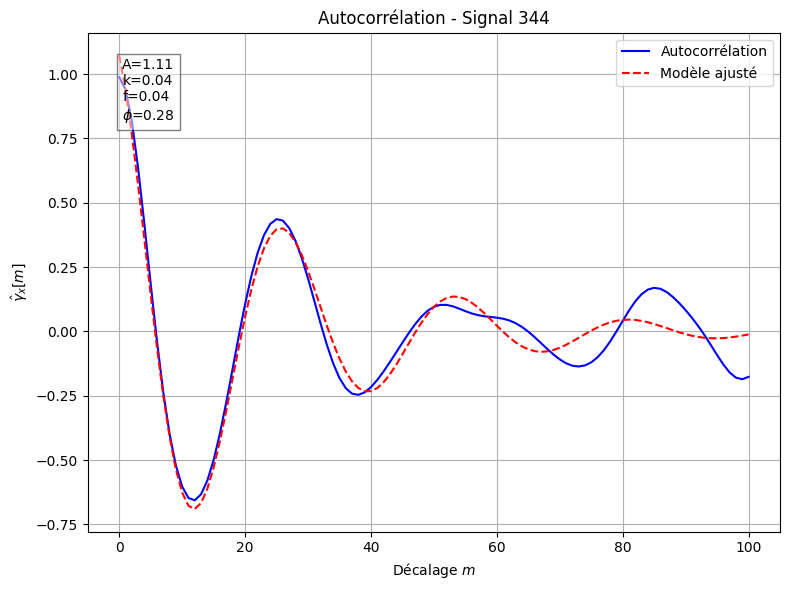

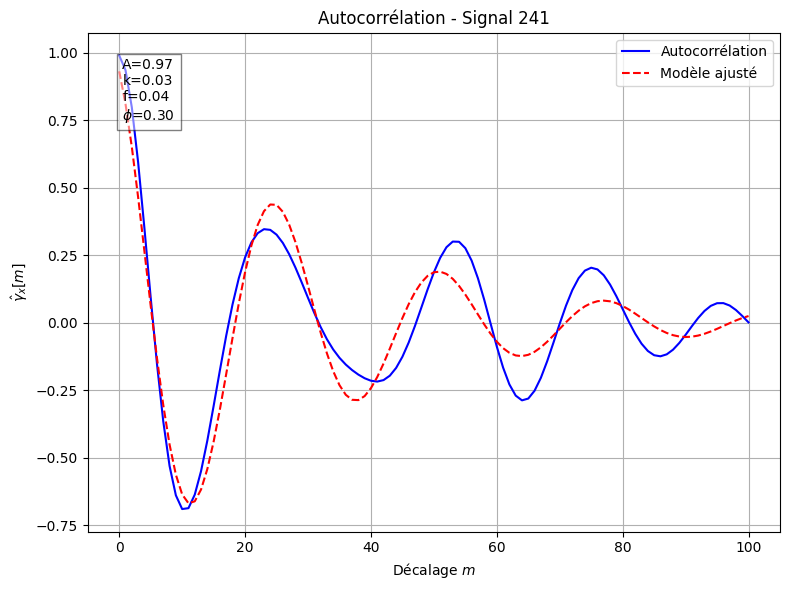

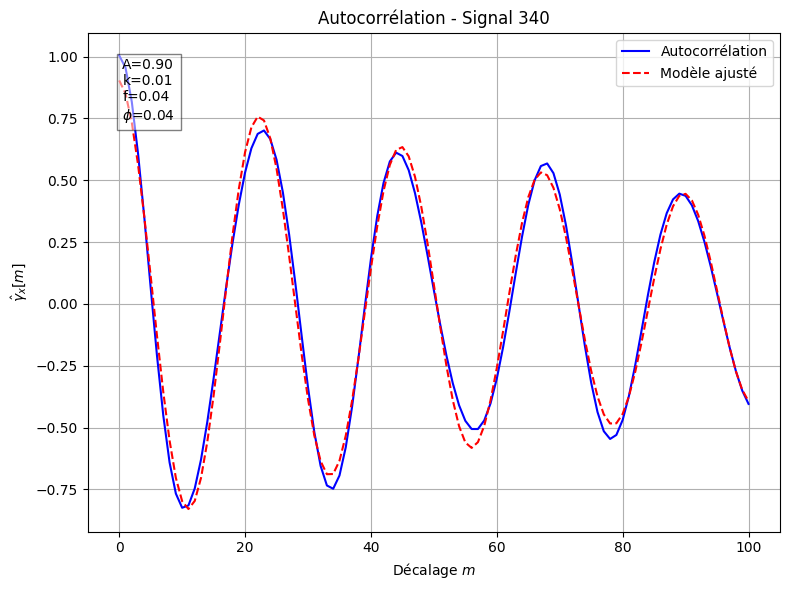

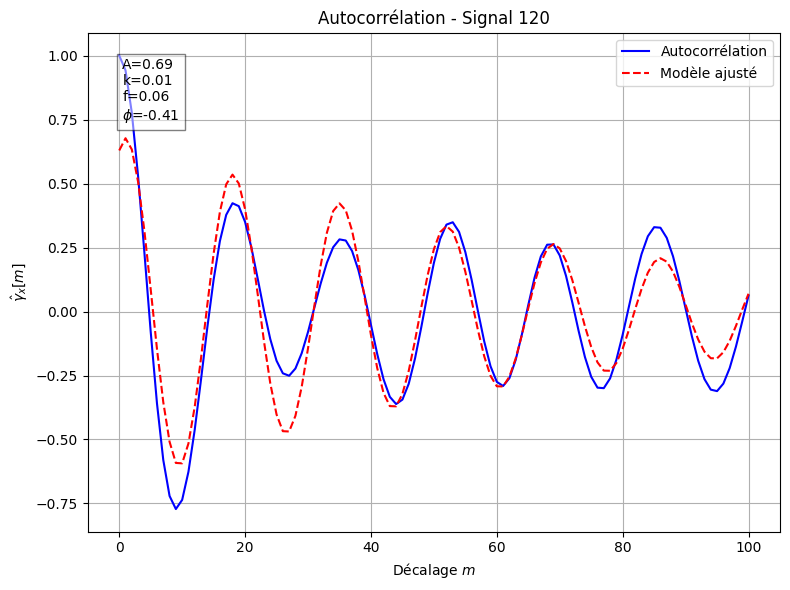

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import random

# Supposons que 'datas' est votre liste de signaux, chaque signal étant une instance de la classe Data

# Paramètres
maxLags = 100
num_signals_to_plot = 10  # Nombre de signaux à traiter

# Option 1 : Sélectionner des signaux aléatoirement
#random.seed(42)  # Pour assurer la reproductibilité
signal_indices = random.sample(range(len(datas)), num_signals_to_plot)

# Option 2 : Spécifier les indices des signaux manuellement
# signal_indices = [0, 1, 2, 3, 4]  # Par exemple


def damped_sine(m, A, k, f, phi):
    return A * np.exp(-k * m) * np.cos(2 * np.pi * f * m + phi)

for idx in signal_indices:
    data = datas[idx]
    
    gammax, lags = autocorrelation(data.values, maxLags)
    
    positive_lags = lags[lags >= 0]
    autocorr = gammax[lags >= 0]
    lags_fit = positive_lags[1:]
    autocorr_fit = autocorr[1:]
    
    initial_guess = [1, 0.01, 0.05, 0]
    try:
        popt, _ = curve_fit(damped_sine, lags_fit, autocorr_fit, p0=initial_guess)
        A_fitted, k_fitted, f_fitted, phi_fitted = popt
        autocorr_fitted = damped_sine(positive_lags, *popt)
        
        # Créer une nouvelle figure pour chaque signal
        plt.figure(figsize=(8, 6))
        plt.plot(positive_lags, autocorr, linestyle='-', color='blue', label='Autocorrélation')
        plt.plot(positive_lags, autocorr_fitted, linestyle='--', color='red', label='Modèle ajusté')
        plt.title(f'Autocorrélation - Signal {data.index}')
        plt.ylabel('$\\hat{{\\gamma}}_x[m]$')
        plt.xlabel('Décalage $m$')
        plt.grid(True)
        plt.legend()
        
        # Afficher les paramètres ajustés sur le graphique
        plt.text(0.05, 0.95, f'A={A_fitted:.2f}\nk={k_fitted:.2f}\nf={f_fitted:.2f}\n$\\phi$={phi_fitted:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.5))
        plt.tight_layout()
        plt.show()
    except RuntimeError:
        # En cas d'échec de l'ajustement
        plt.figure(figsize=(4, 3))
        plt.plot(positive_lags, autocorr, linestyle='-', color='blue')
        plt.title(f'Autocorrélation - Signal {data.index}')
        plt.ylabel('$\\hat{{\\gamma}}_x[m]$')
        plt.xlabel('Décalage $m$')
        plt.grid(True)
        plt.text(0.5, 0.5, 'Ajustement échoué', transform=plt.gca().transAxes, ha='center', va='center', color='red')
        plt.tight_layout()
        plt.show()
